In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

Using TensorFlow backend.


In [31]:
import os
import glob 
import nrrd
import numpy as np

parentDir="/home/ki/data/exampledata/"

if not os.path.exists(parentDir):
	os.makedirs(parentDir)
# extract the zipfile

if not False:
	fileList = sorted(glob.glob(parentDir+"*.nrrd"))
else:
	fileList = sorted(glob.glob(parentDir+"PrepOuputMoreParticles/cropped/*.nrrd"))

print(fileList)
(xmax,ymax,zmax)=(0,0,0)
numdata=len(fileList)
for filename in fileList:
    readdata, header = nrrd.read(filename)
    print(header['sizes'])
    print(readdata.shape)
    xmax=max(xmax,readdata.shape[0])
    ymax=max(ymax,readdata.shape[1])
    zmax=max(zmax,readdata.shape[2])

print(xmax,ymax,zmax)

['/home/ki/data/exampledata/Paient16.nrrd', '/home/ki/data/exampledata/Pateit12.nrrd', '/home/ki/data/exampledata/Patient11.nrrd', '/home/ki/data/exampledata/Patient14.nrrd', '/home/ki/data/exampledata/Patient15.nrrd', '/home/ki/data/exampledata/Patient17.nrrd']
[338 370 242]
(338, 370, 242)
[332 393 217]
(332, 393, 217)
[303 392 238]
(303, 392, 238)
[293 454 295]
(293, 454, 295)
[315 426 167]
(315, 426, 167)
[284 394 220]
(284, 394, 220)
338 454 295


In [79]:
from skimage.transform import downscale_local_mean


xmax=360
ymax=480
zmax=360

mydata=np.zeros((numdata,xmax,ymax,zmax))
mysmalldata=np.zeros((numdata,36,48,36,1))

index=0
for filename in fileList:
    readdata, header = nrrd.read(filename)
    print(header['sizes'])
    print(readdata.shape)
    xpad=xmax- readdata.shape[0]
    xpad1=int(xpad/2)
    xpad2=xpad1 if  xpad1==xpad/2.0 else xpad1+1
    
    ypad=ymax- readdata.shape[1]
    ypad1=int(ypad/2)
    ypad2=ypad1 if  ypad1==ypad/2.0 else ypad1+1
    
    zpad=zmax- readdata.shape[2]
    zpad1=int(zpad/2)
    zpad2=zpad1 if  zpad1==zpad/2.0 else zpad1+1
    
    paddeddata=np.pad(readdata,((xpad1,xpad2),(ypad1,ypad2),(zpad1,zpad2)),mode='constant')
    
    transformeddata=downscale_local_mean(paddeddata,(10,10,10))
    tdata=np.reshape(transformeddata,(36,48,36,1))

    
    mydata[index,:,:,:]=paddeddata
    mysmalldata[index,:,:,:]=tdata
    index+=1
    print("padded:",paddeddata.shape)



[338 370 242]
(338, 370, 242)
padded: (360, 480, 360)
[332 393 217]
(332, 393, 217)
padded: (360, 480, 360)
[303 392 238]
(303, 392, 238)
padded: (360, 480, 360)
[293 454 295]
(293, 454, 295)
padded: (360, 480, 360)
[315 426 167]
(315, 426, 167)
padded: (360, 480, 360)
[284 394 220]
(284, 394, 220)
padded: (360, 480, 360)


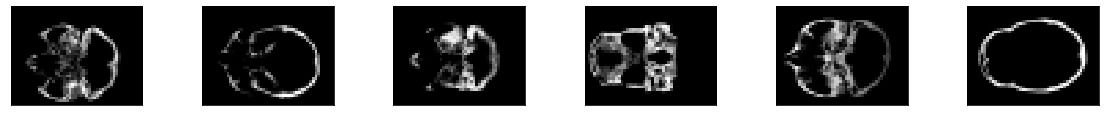

In [88]:
import matplotlib.pyplot as plt

n = numdata  # how many images we will display
plt.figure(figsize=(20, 4))
slice=10
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mysmalldata[i,:,:,slice,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
slice=15
for i in range(n):
    # display original
    plt.imshow(mysmalldata[i,:,:,slice,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

In [106]:
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(36, 48, 36,1))  # adapt this if using `channels_first` image data format

x = Conv3D(16, (3, 3,3), activation='relu', padding='same')(input_img)
x = MaxPooling3D((2, 2,2), padding='same')(x)
x = Conv3D(8, (3, 3,3), activation='relu', padding='same')(x)
x = MaxPooling3D((2, 2,2), padding='same')(x)
x = Conv3D(8, (3, 3,3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((1, 1,1), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv3D(8, (3, 3,3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2,2))(x)
x = Conv3D(8, (3, 3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2,2))(x)
decoded = Conv3D(1, (3, 3,3), activation='relu',padding='same')(x)
#x = UpSampling3D((2, 2,2))(x)
#decoded = Conv3D(1, (3, 3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [112]:
autoencoder.fit(mysmalldata, mysmalldata,
                epochs=20,
                batch_size=128,
                shuffle=True)

Epoch 1/20
6/6 [==============================] - 3s 467ms/step - loss: 0.4066
Epoch 2/20
6/6 [==============================] - 0s 43ms/step - loss: 0.1627
Epoch 3/20
6/6 [==============================] - 0s 45ms/step - loss: 0.1564
Epoch 4/20
6/6 [==============================] - 0s 38ms/step - loss: 0.1533
Epoch 5/20
6/6 [==============================] - 0s 42ms/step - loss: 0.1507
Epoch 6/20
6/6 [==============================] - 0s 44ms/step - loss: 0.1483
Epoch 7/20
6/6 [==============================] - 0s 44ms/step - loss: 0.1460
Epoch 8/20
6/6 [==============================] - 0s 41ms/step - loss: 0.1438
Epoch 9/20
6/6 [==============================] - 0s 46ms/step - loss: 0.1417
Epoch 10/20
6/6 [==============================] - 0s 37ms/step - loss: 0.1397
Epoch 11/20
6/6 [==============================] - 0s 40ms/step - loss: 0.1377
Epoch 12/20
6/6 [==============================] - 0s 38ms/step - loss: 0.1358
Epoch 13/20
6/6 [==============================] - 0s 49ms/s

In [108]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 36, 48, 36, 1)     0         
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 36, 48, 36, 16)    448       
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 18, 24, 18, 16)    0         
_________________________________________________________________
conv3d_36 (Conv3D)           (None, 18, 24, 18, 8)     3464      
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 9, 12, 9, 8)       0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 9, 12, 9, 8)       1736      
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 9, 12, 9, 8)       0         
__________

In [111]:
mysmalldata.shape

(6, 36, 48, 36, 1)

In [1]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'x_test' is not defined

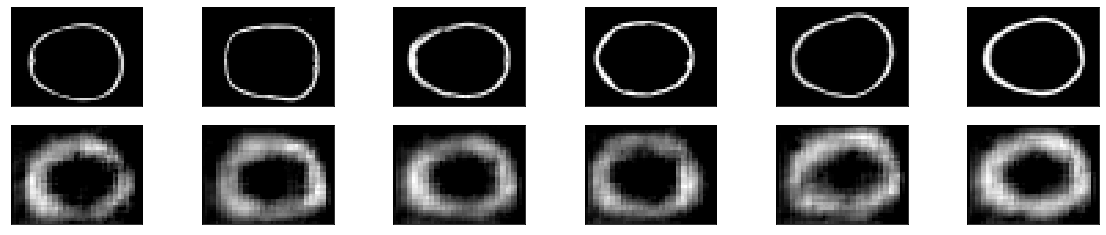

In [116]:
# encode and decode some images
# note that we take them from the *test* set
decoded_imgs = autoencoder.predict(mysmalldata)


n = numdata  # how many images we will display
plt.figure(figsize=(20, 4))
slice=20
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mysmalldata[i,:,:,slice,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i,:,:,slice,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    


plt.show()